In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import numpy as np  
from gcs import path_handler as ph
import gcs
import stream_analysis as sa

/home/sferrone/miniconda3/envs/galstreams2/lib/python3.12/site-packages/stream_analysis-0.1-py3.12.egg/stream_analysis/parametric_stream_fitting.py:56: SyntaxWarning: invalid escape sequence '\s'
/home/sferrone/miniconda3/envs/galstreams2/lib/python3.12/site-packages/stream_analysis-0.1-py3.12.egg/stream_analysis/parametric_stream_fitting.py:56: SyntaxWarning: invalid escape sequence '\s'


In [2]:
# the structre of the plot 
def set_up_plot(Nrows):
    fig=plt.figure(figsize=(10,1.5*Nrows + 1))
    gs=gridspec.GridSpec(Nrows,2, width_ratios=[1,0.01],hspace=0.5,wspace=0.05)
    axis=[]
    if Nrows >=3:
        cbar = fig.add_subplot(gs[1:Nrows-1,1])
    else:
        cbar = fig.add_subplot(gs[:,1])
    for i in range(Nrows):
        axis.append(fig.add_subplot(gs[i,0]))
    return fig,axis,cbar

In [3]:
def extract_to_tail_coordinates(orbitpath,streampath,montecarlokey,internal_dynamics,NP):
    """
    Here to extract the raw data and transform the stream to tail coordinates in one go
    """

    time_of_interest,nDynTimes=0,2
    tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv = gcs.extractors.GCOrbits.extract_whole_orbit(orbitpath,montecarlokey=montecarlokey)
    tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv=sa.tailCoordinates.filter_orbit_by_dynamical_time(tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,time_of_interest,nDynTimes)
    _,xp,yp,zp,vxp,vyp,vzp = gcs.extractors.Stream.extract_old_streams(streampath,internal_dynamics=internal_dynamics,montecarlokey=montecarlokey,NP=NP)
    xT,yT,zT,vxT,vyT,vzT,_ = sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(xp,yp,zp,vxp,vyp,vzp,tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,t0=time_of_interest)
    return xT,yT,zT,vxT,vyT,vzT

In [4]:
## Set the global variables
GCname = "Pal5"
NP = int(1e5)
internal_dynamics = "isotropic-plummer"
montecarlokey="monte-carlo-009"


streamPotentials = ["pouliasis2017pii-GCNBody","pouliasis2017pii-NGC2808","pouliasis2017pii-NGC7078","pouliasis2017pii-NGC104","pouliasis2017pii"]
orbitPotentials = ["pouliasis2017pii-GCNBody","pouliasis2017pii-GCNBody","pouliasis2017pii-GCNBody","pouliasis2017pii-GCNBody","pouliasis2017pii"]
NROWS=len(streamPotentials)

In [5]:
# what is the out file name?
DOMIDPOINT_SHIFT = True
outname = "decomposition-{:s}-with-{:d}-gaps".format(montecarlokey,NROWS-2)
outpath = "../paper/"
if DOMIDPOINT_SHIFT:
    outname += "-domidpoint-shift"

In [6]:
# load the path names
streampaths = [ph.old_streams(MWpotential=potential_env, GCname=GCname,montecarlokey=montecarlokey,NP=NP) for potential_env in streamPotentials]
orbitpaths = [ph.GC_orbits(MWpotential=potential_env, GCname=GCname) for potential_env in orbitPotentials]


In [7]:
# convert all to tail coordiantes
tailcoordinates = [extract_to_tail_coordinates(orbitpath,streampath,montecarlokey,internal_dynamics,NP) for orbitpath,streampath in zip(orbitpaths,streampaths)]

In [8]:
# make the 2D scatter density maps
scatterplots = [ ]
for xT,yT,zT,vxT,vyT,vzT in tailcoordinates:
    XX,YY,H=sa.plotters.binned_density.short_cut(NP,xT,yT,[-10,10],[-1,1])
    H=sa.plotters.binned_density.normalize_density_by_particle_number(H,NP)
    scatterplots.append([XX,YY,H])
# add the last one twice because I also wanna add the tracks for comparison 
scatterplots.append(scatterplots[-1]) 


In [9]:
# set the properties for the scatter plots

cbarlabel=r"Density [$N_p/N$]"
normalScatterProperties = {
    "alpha":0.9, 
    "s":1,
    "cmap":'rainbow',
    "norm":colors.LogNorm(vmin=1e-5, vmax=1e-3)
    }
AXIS={
    "xlabel":"$x_{tail}$ [kpc]",
    "ylabel":"$y_{tail}$ [kpc]",
    "xlim":[-10,10],
    "ylim":[-0.5,0.5],
    "yticks": [0,0.5],
    "xticks": np.arange(-10,11,2),
    "yticks": np.arange(-0.4,0.5,0.2),
}


In [10]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

In [11]:
# edit the titles
titles = []
for x in streamPotentials:
    temp = x.split("-")[-1]
    if temp == "GCNBody":
        titles.append("Full")
    elif temp == "pouliasis2017pii":
        titles.append("Reference")
    else:
        titles.append(r"Reference + $\vec{{F}}_\textrm{{{:s}}}$".format(temp))

titles.append("Reference with GalStream Tracks")

## Load the Stream tracks for length comparison 



In [12]:
import galstreams 
mws = galstreams.MWStreams(verbose=False, implement_Off=True)

Initializing galstreams library from master_log... 


In [13]:
from astropy import coordinates
from astropy import units as u
def MWreferenceframe():
    import yaml 
    absolute_path_to_frame = "/home/sferrone/gcs/scrapnotebooks/MWrefframe001.yaml"
    with open(absolute_path_to_frame, 'r') as frame:
        try:
            frame_data = yaml.safe_load(frame)
        except yaml.YAMLError as exc:
            print(exc)
        galcen_distance=frame_data['value']['galcen_distance']*u.Unit(frame_data['unit']['galcen_distance'])
        z_sun   =   frame_data['value']['z_sun']    *   u.Unit(frame_data['unit']['z_sun'])
        vSun    =   frame_data['value']['vSun']     *   u.Unit(frame_data['unit']['vSun'])
        vLSR    =   frame_data['value']['vLSR']     *   u.Unit(frame_data['unit']['vLSR'])
    return coordinates.Galactocentric(galcen_distance = galcen_distance, galcen_v_sun=vLSR+vSun, z_sun=z_sun)

In [14]:
# load the orbit 
orbitPotential="pouliasis2017pii"
orbitpath = ph.GC_orbits(MWpotential=orbitPotential, GCname=GCname) 
time_of_interest,nDynTimes=0,2
tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv = gcs.extractors.GCOrbits.extract_whole_orbit(orbitpath,montecarlokey=montecarlokey)
tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv=sa.tailCoordinates.filter_orbit_by_dynamical_time(tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,time_of_interest,nDynTimes)

In [15]:
# convert the tracks to tail coordinates
tracknames=mws.get_track_names_for_stream('Pal5')
useabletracknames = [tracknames[1],tracknames[2],tracknames[3]] # the first doesn't have distance data
refframe=MWreferenceframe()
xTs=[]
yTs=[]
midXs=[]
midYs=[]
for trackname in useabletracknames:
    midpoint=mws[trackname].mid_point.transform_to(refframe)
    mytrack=mws[trackname].track.transform_to(refframe)
    xtrack,ytrack,ztrack = mytrack.cartesian.x.to(u.kpc),mytrack.cartesian.y.to(u.kpc),mytrack.cartesian.z.to(u.kpc)
    vxtrack,vytrack,vztrack = mytrack.velocity.d_x.to(u.km/u.s),mytrack.velocity.d_y.to(u.km/u.s),mytrack.velocity.d_z.to(u.km/u.s)
    xMid,yMid,zMid=midpoint.cartesian.x.to(u.kpc),midpoint.cartesian.y.to(u.kpc),midpoint.cartesian.z.to(u.kpc)
    vxMid,vyMid,vzMid=midpoint.velocity.d_x.to(u.km/u.s),midpoint.velocity.d_y.to(u.km/u.s),midpoint.velocity.d_z.to(u.km/u.s)
    if DOMIDPOINT_SHIFT:
        # get the center of mass of the stream
        today_index = np.argmin(np.abs(tOrb-0))
        xCOM,yCOM,zCOM = xGCv[today_index],yGCv[today_index],zGCv[today_index]
        vxCOM,vyCOM,vzCOM = vxGCv[today_index],vyGCv[today_index],vzGCv[today_index]
        # sift mid-point to be at the same position as the COM 
        dx,dy,dz = xCOM-xMid.value,yCOM-yMid.value,zCOM-zMid.value
        dvx,dvy,dvz = vxCOM-vxMid.value,vyCOM-vyMid.value,vzCOM-vzMid.value
        xtrack,ytrack,ztrack = xtrack.value+dx,ytrack.value+dy,ztrack.value+dz
        vxtrack,vytrack,vztrack = vxtrack.value+dvx,vytrack.value+dvy,vztrack.value+dvz
        # verify the shift is correct by unecessarily shifting the midpoint to com 
        xMid,yMid,zMid=xMid.value+dx,yMid.value+dy,zMid.value+dz
        vxMid,vyMid,vzMid=vxMid.value+dvx,vyMid.value+dvy,vzMid.value+dvz
    else:
        xtrack,ytrack,ztrack = xtrack.value,ytrack.value,ztrack.value
        vxtrack,vytrack,vztrack = vxtrack.value,vytrack.value,vztrack.value
        xMid,yMid,zMid=xMid.value,yMid.value,zMid.value
        vxMid,vyMid,vzMid=vxMid.value,vyMid.value,vzMid.value
    xT,yT,zT,vxT,vyT,vzT,_ = sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(xtrack,ytrack,ztrack,vxtrack,vytrack,vztrack,tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,t0=time_of_interest)
    xTMid,yTMid,_,_,_,_,_ = sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(np.array([xMid]),np.array([yMid]),np.array([zMid]),np.array([vxMid]),np.array([vyMid]),np.array([vzMid]),tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,t0=time_of_interest)
    xTs.append(xT)
    yTs.append(yT)
    midXs.append(xTMid)
    midYs.append(yTMid)
    

0
1
2
3
4


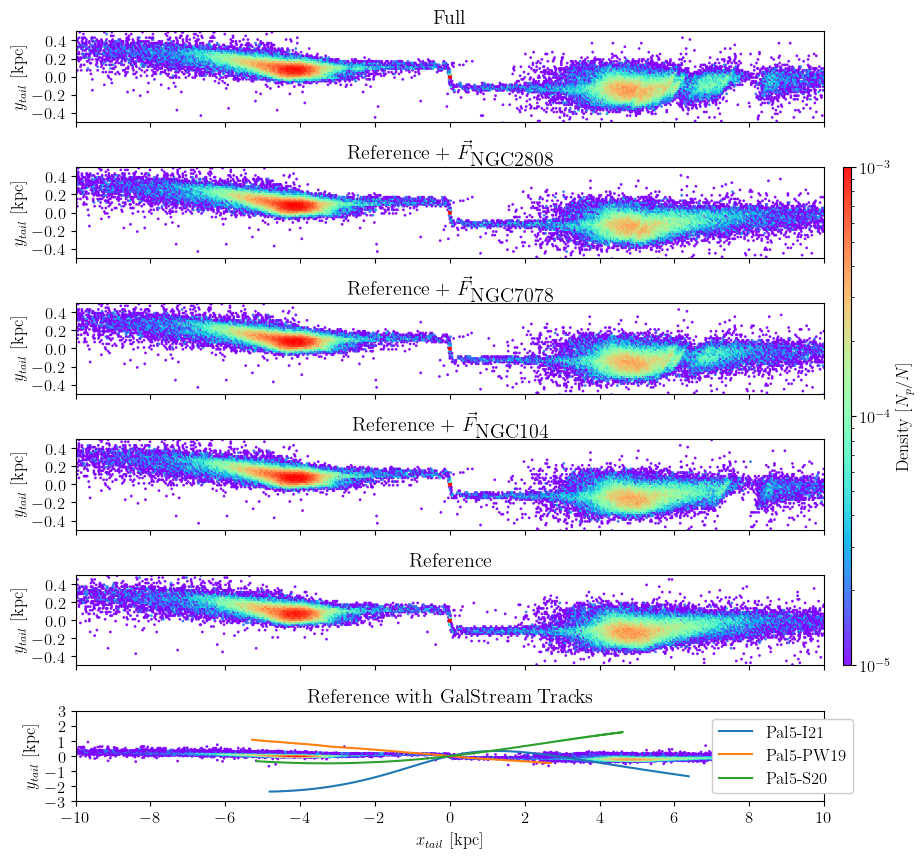

In [16]:
NROWS=len(scatterplots) 
fig,axis,cbar=set_up_plot(NROWS)
for i in range(NROWS):
    if i==0:
        im=axis[i].scatter(scatterplots[i][0],scatterplots[i][1],c=scatterplots[i][2],**normalScatterProperties)
    else:
        axis[i].scatter(scatterplots[i][0],scatterplots[i][1],c=scatterplots[i][2],**normalScatterProperties)
    axis[i].set(**AXIS)

cbar=plt.colorbar(im,cax=cbar)
cbar.set_label(cbarlabel)
for i in range(NROWS):
    axis[i].set(**AXIS)
    axis[i].set_title(titles[i])
    if i!=NROWS-1:
        print(i)
        axis[i].set_xticklabels([])
        axis[i].set_xlabel("")


LASTAXIS = AXIS.copy()
LASTAXIS["ylim"] = [-3,3]
LASTAXIS["yticks"] = np.arange(LASTAXIS['ylim'][0],LASTAXIS['ylim'][1]+1,1)
for i in range(len(useabletracknames)):
    trackColor=axis[-1].plot(xTs[i],yTs[i],label=useabletracknames[i])
    if not DOMIDPOINT_SHIFT:
        axis[-1].scatter(midXs[i],midYs[i],label=useabletracknames[i],s=100,marker='x',color=trackColor.get_facecolor())

axis[-1].set(**LASTAXIS);
legend=axis[-1].legend(frameon=True, loc='center right', bbox_to_anchor=(1.05, 0.5))
legend.get_frame().set_alpha(None)

fig.savefig(outpath+outname+".png",dpi=300)